# Introduction

Sandberg et al paper: 
https://arxiv.org/abs/1806.02404

Original MatLab code used by Sandberg can be found here: 
https://github.com/AndersSandberg/dissolving-Fermi

Critical response with link to coding attempt (inspired current notebook):
https://forum.effectivealtruism.org/posts/kvZshdx5FzTPjyhxG/the-fermi-paradox-has-not-been-dissolved

Re-estimate of probability of life based on Totani: 
https://www.nature.com/articles/s41598-020-58060-0

Better set-up for prior distibutions and posterior likelihoods taken from:
https://www.pnas.org/doi/10.1073/pnas.1921655117
https://arxiv.org/abs/2010.12358


In [1]:
# Load libraries
import arviz as az
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm

#Functions

In [2]:
def drake_sims(n_trials=10**6, R_min=0, R_max=2, 
               fp_min=-1, fp_max=0, 
               ne_min=-1, ne_max=0, 
               fl_mean=1, fl_sd=50, 
               fi_min=-3, fi_max=0, 
               fc_min=-2, fc_max=0, 
               L_min=2, L_max=10):
  """
  Simulate order of magnitude of number of civilizations in the Milky Way

  """

  N_storage = np.zeros(n_trials)

  #draw parameters from distribution
  for trial in tqdm(range(0, n_trials)):
    # Log-uniform
    R = random.uniform(R_min, R_max)
    fp = random.uniform(fp_min, fp_max)
    ne = random.uniform(ne_min, ne_max)

    # Log-normal
    param = random.gauss(fl_mean, fl_sd) #critical fl parameter
    if param < -10: #needed to avoid getting 0 rounding errors
        fl = param
    elif param > 10: #overflow avoidance
        fl = 0.0
    else:
        fl = np.log10(1.0 - np.exp(-10.0**param))

    #Log-uniform again
    fi = random.uniform(fi_min, fi_max)
    fc = random.uniform(fc_min, fc_max)
    L = random.uniform(L_min, L_max)

    N = R+fp+ne+fl+fi+fc+L #calculate fermi estimate for given values
    N_storage[trial]= N #store estimate

  return N_storage

In [3]:
def drake_sims_v4(n_trials=10**6, R_min=0, R_max=2, 
               fp_min=-1, fp_max=0, 
               ne_min=-1, ne_max=0, 
               fl_alpha=0.5, fl_beta=0.5, 
               fl_bayes_factor=3.0, 
               fi_alpha=0.5, fi_beta=0.5, 
               fi_bayes_factor=0.67, 
               fc_min=-2, fc_max=0, 
               L_mean = 10**3):
  """
  Simulate order of magnitude of number of civilizations in the Milky Way

  """

  #draw parameters from distribution
  R = np.random.uniform(R_min, R_max, size=n_trials)
  fp = np.random.uniform(fp_min, fp_max, size=n_trials)
  ne = np.random.uniform(ne_min, ne_max, size=n_trials)

  fl = stats.beta.rvs(fl_alpha, fl_beta, size=n_trials)
  fl = np.log10(fl_bayes_factor) + np.log10(fl) - \
          np.log10(fl_bayes_factor*fl - fl + 1)

  fi = stats.beta.rvs(fi_alpha, fi_beta, size=n_trials)
  fi = np.log10(fi_bayes_factor) + np.log10(fi) - \
          np.log10((fi_bayes_factor)*fi - fi + 1)

  fc = np.random.uniform(fc_min, fc_max, size=n_trials)
  L = np.log10(np.random.exponential(L_mean, size=n_trials))

  N_storage = R+fp+ne+fl+fi+fc+L #calculate fermi estimate for given values

  return N_storage

In [4]:
def drake_sims_v5(n_trials=10**6, 
               fl_alpha=0.5, fl_beta=0.5, 
               fl_bayes_factor=3.0, 
               fi_alpha=0.5, fi_beta=0.5, 
               fi_bayes_factor=0.67, 
               fc_alpha=0.5, fc_beta=0.5, 
               L_mean = 10**3):
  """
  Simulate order of magnitude of number of civilizations in the Milky Way

  Details of number of planets in Kepler dataset taken from
    https://exoplanetarchive.ipac.caltech.edu/docs/counts_detail.html
  """

  # Recent galactic star formation rate
  # >1.65 solar masses per year into new stars
  # About 0.5 solar masses per new star
  rate_of_star_formation = 3 # per year
  # Values from Kepler space telescope data
  num_kepler_stars_observed = 150000
  # About 2% of all planets in correct orientation to be detected
  # by transit method
  num_stars_correct_orien = 0.02*num_kepler_stars_observed
  num_kepler_planets_confirmed = 2708
  mean_num_stars_w_planet = num_kepler_planets_confirmed/num_stars_correct_orien
  num_kepler_hab_planets_confirmed = 361

  R = np.random.gamma(shape=rate_of_star_formation, 
                      scale=1, # per one year
                      size=n_trials)
  fp = np.random.beta(num_kepler_planets_confirmed, 
                      (1-mean_num_stars_w_planet)*num_stars_correct_orien,
                      size=n_trials)
  ne = np.random.gamma(shape=num_kepler_hab_planets_confirmed, 
                       scale=1/num_kepler_planets_confirmed, 
                       size=n_trials)
  fl = np.random.beta(fl_alpha, fl_beta, size=n_trials)
  fi = np.random.beta(fi_alpha, fi_beta, size=n_trials)
  fc = np.random.beta(fc_alpha, fc_beta, size=n_trials)

  R = np.log10(R)
  fp = np.log10(fp)
  ne = np.log10(ne)
  fl = np.log10(fl_bayes_factor) + np.log10(fl) - \
        np.log10(fl_bayes_factor*fl - fl + 1)
  fi = np.log10(fi_bayes_factor) + np.log10(fi) - \
        np.log10((fi_bayes_factor)*fi - fi + 1)
  fc = np.log10(fc)

  L = np.log10(np.random.exponential(L_mean, size=n_trials))

  N_storage = R+fp+ne+fl+fi+fc+L #calculate fermi estimate for given values

  return N_storage

In [5]:
def plot_prior_frequency_of_num_civs(N_storage, subtitle=None):
  """
  Plotting the distrubtion of Drake equation simulations based on the uncertainties 
  of parameters, but before considering a lack of detection of ETI.

  """

  #get bins
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(0.1,0.1))
  _, bins, _ = ax.hist(N_storage, bins=1000)

  #plot in log form
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,4))
  ax.hist(N_storage, bins=bins, 
          weights=np.zeros_like(N_storage)+1./len(N_storage), 
          color="0.1")
  ax.tick_params(axis="x", labelsize=13)
  ax.tick_params(axis="y", labelsize=13)
  plt.axvline(x=-10, color='0.5', 
              linestyle='--', 
              label="Alone in Universe") #line for alone in universe
  plt.axvline(x=0, color='0.3', 
              linestyle='--', 
              label="Alone in Milky Way") #line for alone in Milky Way
  plt.xlim(-40, 12)
  plt.suptitle("Probability Density Function", y=1.02, fontsize=16)
  plt.title(subtitle)
  plt.xlabel("log$_{10}$($N$)")
  plt.ylabel("Frequency")
  plt.show()

  #print results
  p_Earth_alone_in_MW = stats.percentileofscore(N_storage, 0, kind='rank')
  p_Earth_alone_in_U = stats.percentileofscore(N_storage, -10, kind='rank')
  hdi_interval = az.hdi(N_storage, hdi_prob=0.95)
  print('mean number of civilisations in milky way: {:.2e}'.format(np.mean(10**N_storage)))
  print('median number of civilisations in milky way: {:.2f}'.format(np.median(10**N_storage)))
  print(f"  N_mw 95% credible interval: {10**hdi_interval[0]:.2e}, {10**hdi_interval[1]:.2e}")
  print('probability Earth is alone in the milky way: {:.6f}'.format(p_Earth_alone_in_MW))
  print('probability Earth is alone in the universe: {:.6f}'.format(p_Earth_alone_in_U))

In [6]:
def plot_probability_of_n_civs(N_storage):
  """
  Plotting the probability of there being N < n civilizations as n increases. This 
  plot helps visualize the cutoffs.
  
  """

  # Probability N < n plot
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12.1,6.1))
  ranks = []
  for i in range(0,10**4):
    ranks.append(random.uniform(-40, 12))

  rank_probs = []
  for rank in ranks:
    rank_probs.append(stats.percentileofscore(N_storage, rank, kind='rank')/100)

  ax.scatter(ranks, rank_probs)

  ax.tick_params(axis="x", labelsize=13)
  ax.tick_params(axis="y", labelsize=13)
  plt.axvline(x=-10, color='red', 
              linestyle='--', 
              label="Alone in Milky Way") #line for alone in universe
  plt.axvline(x=0, color='blue', 
              linestyle='--', 
              label="Alone in Universe") #line for alone in Milky Way
  plt.xlim(-40, 12)
  plt.title("Cumulative Density Function", fontsize=16)
  plt.xlabel("log$_{10}$($N$)")
  plt.ylabel("P($N$) < x")
  plt.grid(True)
  plt.show()

In [7]:
def plot_prosterier_frequency_of_civs(N_storage, true_list, subtitle=None):
  """
  Plot the distrubtion of Drake equation simulations with and without including 
  the evidence of no detections, leading to a posterior distribution. 

  """

  N_orig = N_storage
  N_posterior = N_storage[true_list]

  #get linear bins to use for log bins definition
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(0.1,0.1))
  _, bins, _ = ax.hist(N_posterior, bins=1000)
  _, orig_bins, _ = ax.hist(N_orig, bins=1000)

  #plot in log form
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,4))
  ax.hist(N_posterior, bins=bins, 
          weights=np.zeros_like(N_posterior)+1./len(N_posterior), 
          alpha=0.33, label='posterior', 
          color='0.1')
  ax.hist(N_orig, bins=orig_bins, 
          weights=np.zeros_like(N_orig)+1./len(N_orig), 
          alpha=0.33, label='prior', 
          color='0.6')
  ax.tick_params(axis="x", labelsize=13)
  ax.tick_params(axis="y", labelsize=13)
  plt.axvline(x=-10, color='0.7', 
              linestyle='--', 
              label="Alone in Universe") #line for alone in universe
  plt.axvline(x=0, color='0.4', 
              linestyle='--', 
              label="Alone in Milky Way") #line for alone in Milky Way
  plt.xlim(-40, 12)
  plt.suptitle("Probability Density Function", y=1.02, fontsize=16)
  plt.title(subtitle)
  plt.xlabel("log$_{10}$($N$)")
  plt.ylabel("Frequency")
  plt.legend(loc='upper left')
  plt.show()

  #print results
  p_Earth_alone_in_MW = stats.percentileofscore(N_posterior, 0, kind='rank')
  p_Earth_alone_in_U = stats.percentileofscore(N_posterior, -10, kind='rank')
  hdi_interval = az.hdi(N_posterior, hdi_prob=0.95)
  print('mean number of civilisations in milky way: {:.4e}'.format(np.mean(10**N_posterior)))
  print('median number of civilisations in milky way: {:.4f}'.format(np.median(10**N_posterior)))
  print(f"  N_mw 95% credible interval: {10**hdi_interval[0]:.2e}, {10**hdi_interval[1]:.2e}")
  print('probability Earth is alone in the milky way: {:.6f}'.format(p_Earth_alone_in_MW))
  print('probability Earth is alone in the universe: {:.6f}'.format(p_Earth_alone_in_U))

In [8]:
def is_detected_poisson_dist(num_expected, 
                             volume=2.30*10**11, distance_scanned=18*2):
  """
  Determine if a given simualtion could provide a detectable civilization, given 
  the expected number of civilizations in the galaxy, a spatial Poisson distrubtion 
  of those civilizations, the volume of space they occupy (i.e., the volume of the 
  Milky Way), and the distance scanned for alien signals.

  The result is a list of simulations that are likely to be legitimate even no ETI 
  has been detected within the distance scanned.

  Input:
    The number of civilizations should be an order of magnitude.
    The volume should be in cubic parsecs (pc^3).
    The distance scanned should be in parces (pc).

  Output:
    List of simulations where a detection was expected. Values in list are binary.

  """

  proba = np.zeros(len(num_expected))

  for i, val in enumerate(num_expected):
    log_factors = val - np.log10(volume) + (3*np.log10(distance_scanned))
    exp_factor = (4*np.pi/3) * (10**log_factors)
    if exp_factor < 10**-10:
      proba[i] = 1.0 - exp_factor
    else:
      proba[i] = np.exp(-exp_factor)

  proba = proba > np.random.rand(len(num_expected))

  return proba

# Original Sim Run and Results

In [9]:
N_original_paper = drake_sims(fl_sd=50)

100%|██████████| 1000000/1000000 [00:10<00:00, 92719.69it/s]


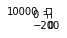

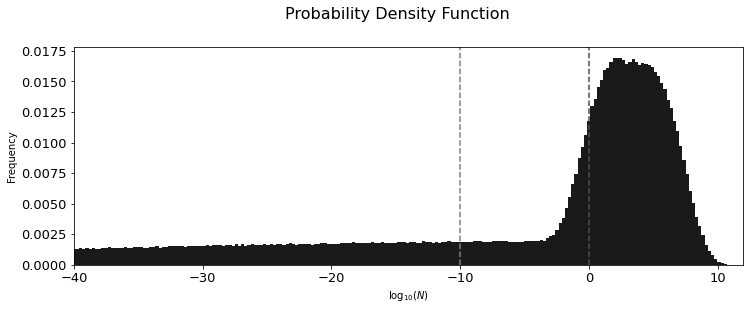

mean number of civilisations in milky way: 2.71e+07
median number of civilisations in milky way: 0.49
  N_mw 95% credible interval: 7.63e-79, 6.19e+09
probability Earth is alone in the milky way: 51.400600
probability Earth is alone in the universe: 38.574600


In [10]:
plot_prior_frequency_of_num_civs(N_original_paper)

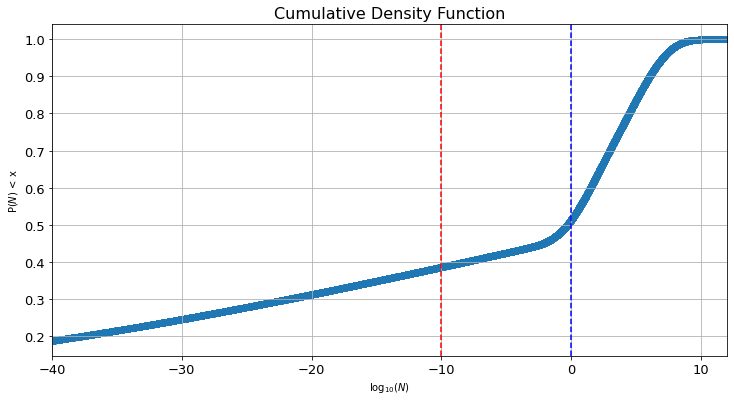

In [11]:
plot_probability_of_n_civs(N_original_paper)

In [12]:
is_detected_list = is_detected_poisson_dist(N_original_paper)

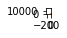

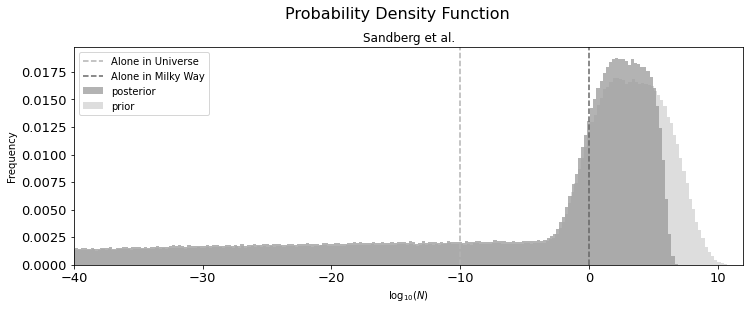

mean number of civilisations in milky way: 3.3343e+04
median number of civilisations in milky way: 0.0020
  N_mw 95% credible interval: 1.78e-81, 3.88e+06
probability Earth is alone in the milky way: 57.954827
probability Earth is alone in the universe: 43.493350


In [13]:
plot_prosterier_frequency_of_civs(N_original_paper, is_detected_list, subtitle="Sandberg et al.")

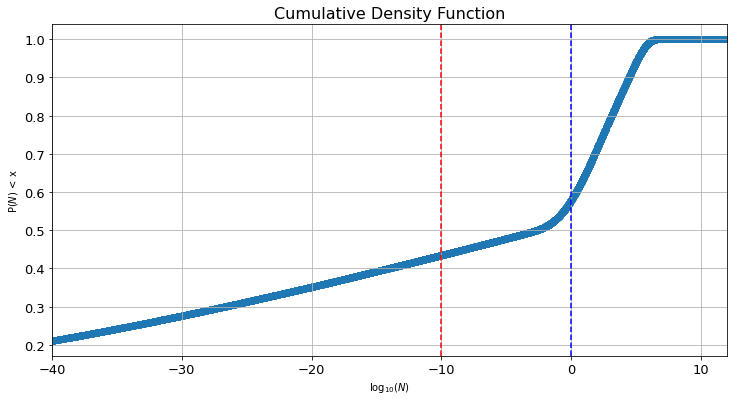

In [14]:
plot_probability_of_n_civs(N_original_paper[is_detected_list])

# New Sim Run

In [15]:
N_new_results = drake_sims(fl_sd=15)

100%|██████████| 1000000/1000000 [00:05<00:00, 191223.85it/s]


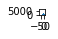

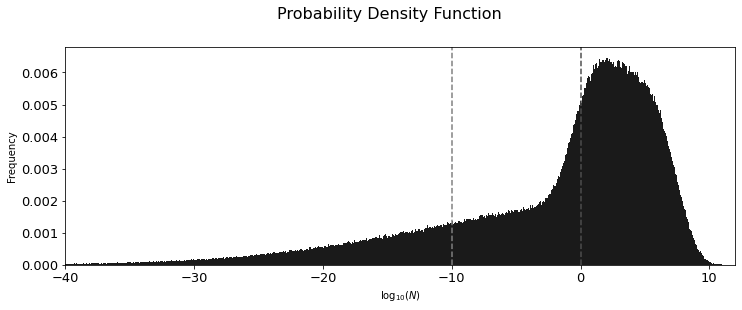

mean number of civilisations in milky way: 3.00e+07
median number of civilisations in milky way: 8.06
  N_mw 95% credible interval: 8.36e-22, 1.34e+09
probability Earth is alone in the milky way: 43.491800
probability Earth is alone in the universe: 17.047700


In [16]:
plot_prior_frequency_of_num_civs(N_new_results)

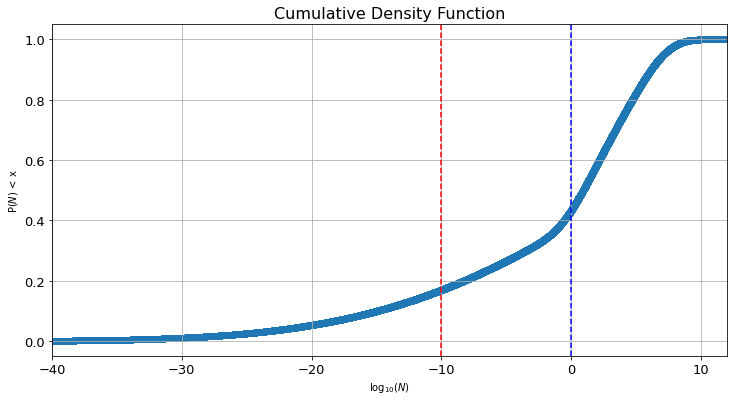

In [17]:
plot_probability_of_n_civs(N_new_results)

In [18]:
new_is_detected_list = is_detected_poisson_dist(N_new_results)

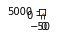

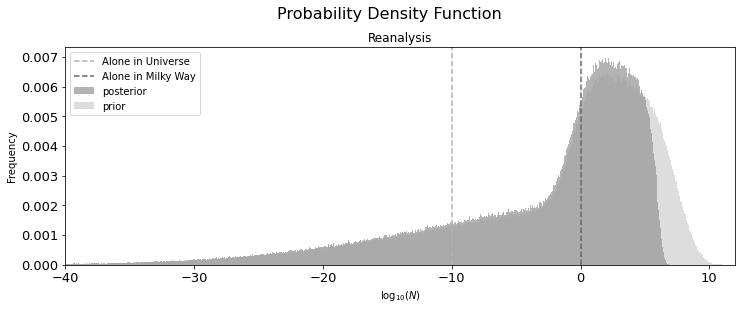

mean number of civilisations in milky way: 3.7413e+04
median number of civilisations in milky way: 1.1580
  N_mw 95% credible interval: 2.51e-22, 2.78e+06
probability Earth is alone in the milky way: 49.540553
probability Earth is alone in the universe: 19.418660


In [19]:
plot_prosterier_frequency_of_civs(N_new_results, new_is_detected_list, "Reanalysis")

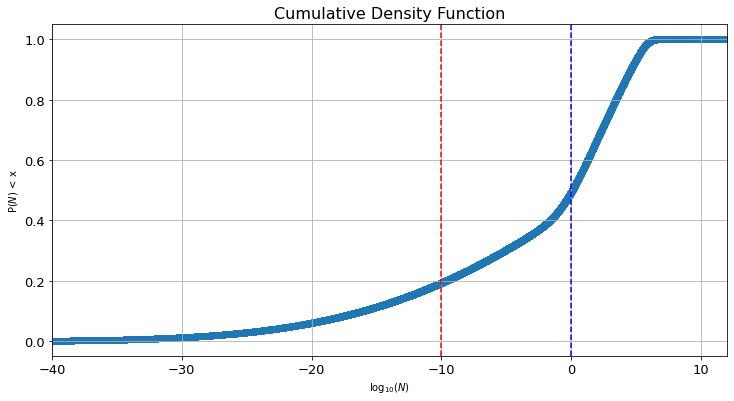

In [20]:
plot_probability_of_n_civs(N_new_results[new_is_detected_list])

# Crazy Optimistic

In [21]:
N_optimistic_results = drake_sims(fl_sd=0.33)

100%|██████████| 1000000/1000000 [00:06<00:00, 143814.07it/s]


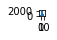

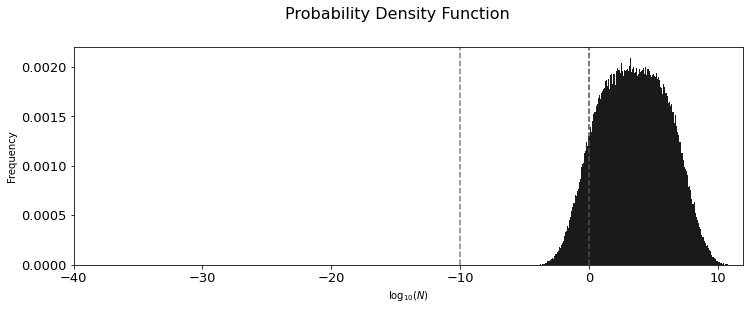

mean number of civilisations in milky way: 5.40e+07
median number of civilisations in milky way: 3106.55
  N_mw 95% credible interval: 4.76e-02, 1.98e+08
probability Earth is alone in the milky way: 10.023000
probability Earth is alone in the universe: 0.000000


In [22]:
plot_prior_frequency_of_num_civs(N_optimistic_results)

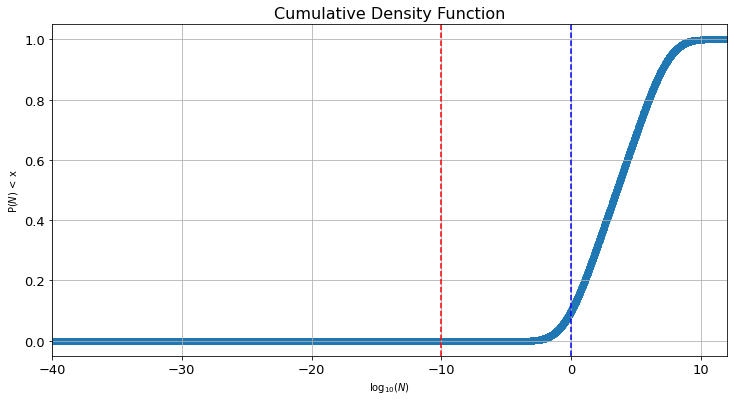

In [23]:
plot_probability_of_n_civs(N_optimistic_results)

In [24]:
optimistic_is_detected_list = is_detected_poisson_dist(N_optimistic_results)

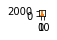

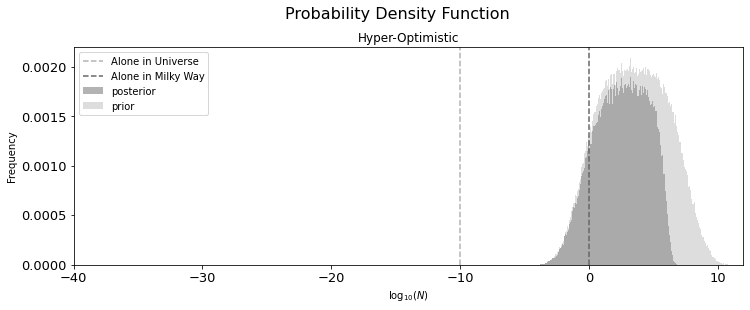

mean number of civilisations in milky way: 7.2790e+04
median number of civilisations in milky way: 417.2520
  N_mw 95% credible interval: 6.65e-02, 1.25e+06
probability Earth is alone in the milky way: 12.810550
probability Earth is alone in the universe: 0.000000


In [25]:
plot_prosterier_frequency_of_civs(N_optimistic_results, optimistic_is_detected_list, subtitle="Hyper-Optimistic")

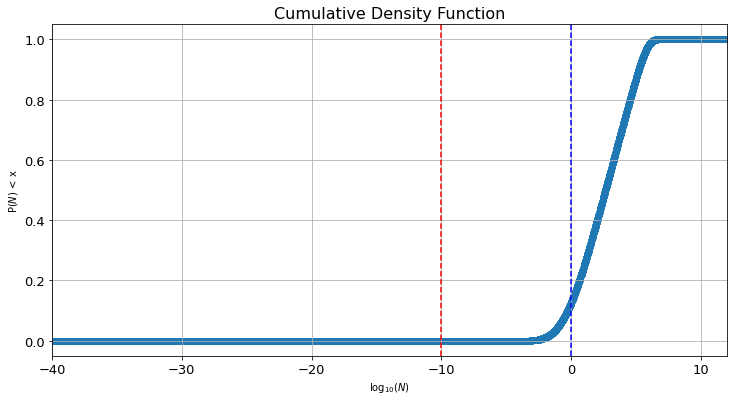

In [26]:
plot_probability_of_n_civs(N_optimistic_results[optimistic_is_detected_list])

# Better Version of Priors

In [27]:
N_better_results = drake_sims_v5(n_trials=10**6, fl_alpha=0.5, fl_beta=0.5, 
                                 fi_alpha=0.5, fi_beta=0.5, L_mean=3*10**2)

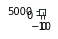

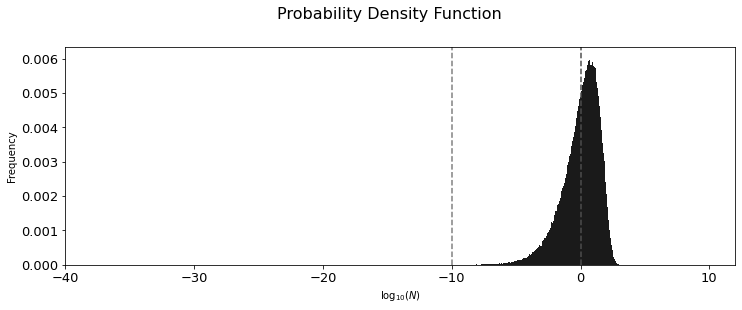

mean number of civilisations in milky way: 1.54e+01
median number of civilisations in milky way: 1.91
  N_mw 95% credible interval: 1.18e-03, 2.30e+02
probability Earth is alone in the milky way: 41.981600
probability Earth is alone in the universe: 0.005300


In [28]:
plot_prior_frequency_of_num_civs(N_better_results)

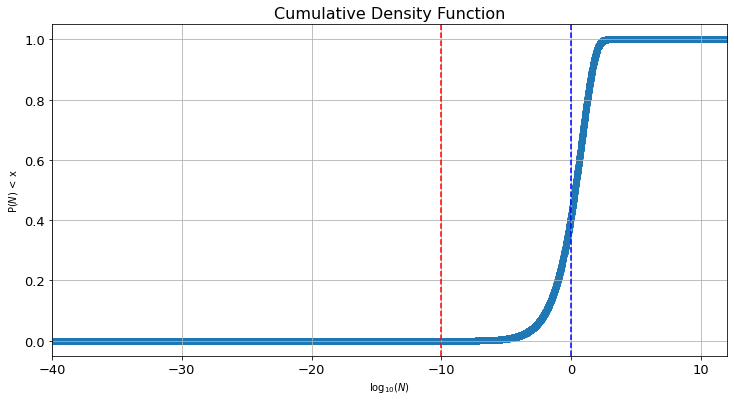

In [29]:
plot_probability_of_n_civs(N_better_results)

In [30]:
better_is_detected_list = is_detected_poisson_dist(N_better_results)

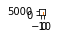

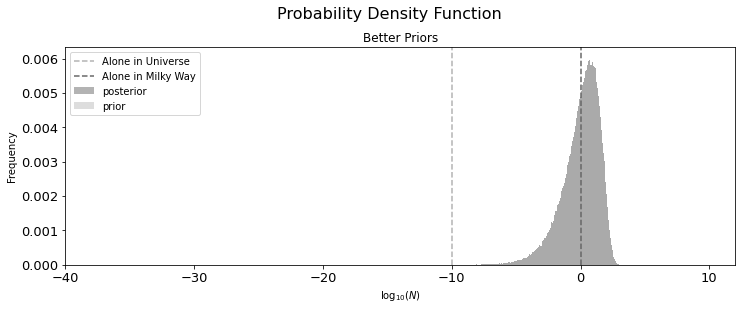

mean number of civilisations in milky way: 1.5383e+01
median number of civilisations in milky way: 1.9080
  N_mw 95% credible interval: 1.18e-03, 2.30e+02
probability Earth is alone in the milky way: 41.981978
probability Earth is alone in the universe: 0.005300


In [31]:
plot_prosterier_frequency_of_civs(N_better_results, better_is_detected_list, subtitle="Better Priors")

##Life found in the Solar System

In [32]:
N_ss_life_results = drake_sims_v5(n_trials=10**6, fl_alpha=2, fl_beta=1, 
                                  fi_alpha=0.5, fi_beta=0.5, 
                                  fc_alpha=0.5, fc_beta=0.5, 
                                  L_mean=3*10**2)

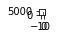

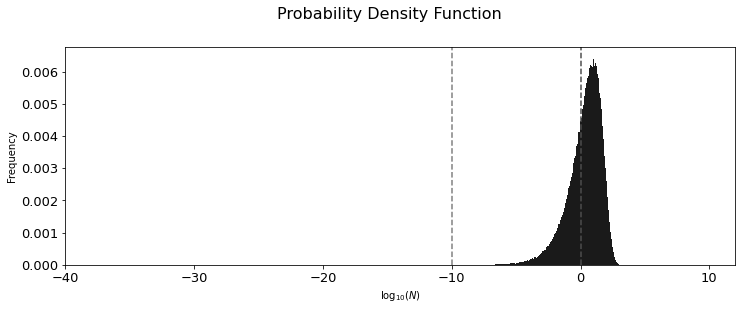

mean number of civilisations in milky way: 2.00e+01
median number of civilisations in milky way: 3.57
  N_mw 95% credible interval: 4.53e-03, 2.63e+02
probability Earth is alone in the milky way: 33.477200
probability Earth is alone in the universe: 0.001600


In [33]:
plot_prior_frequency_of_num_civs(N_ss_life_results)

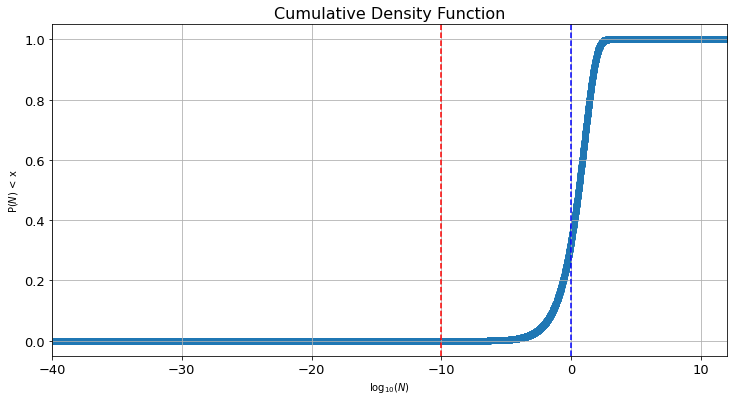

In [34]:
plot_probability_of_n_civs(N_ss_life_results)

In [35]:
ss_life_is_detected_list = is_detected_poisson_dist(N_ss_life_results)

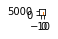

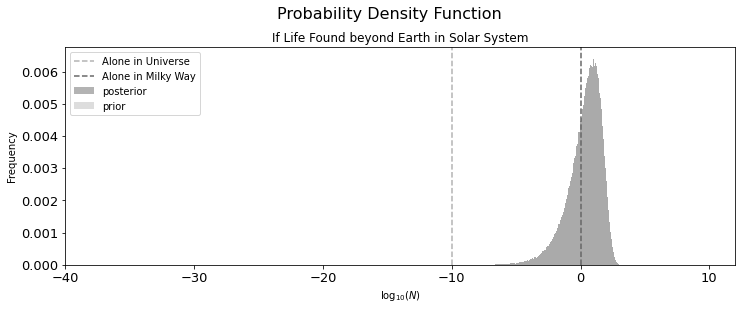

mean number of civilisations in milky way: 2.0037e+01
median number of civilisations in milky way: 3.5745
  N_mw 95% credible interval: 4.53e-03, 2.63e+02
probability Earth is alone in the milky way: 33.477836
probability Earth is alone in the universe: 0.001600


In [36]:
plot_prosterier_frequency_of_civs(N_ss_life_results, ss_life_is_detected_list, subtitle="If Life Found beyond Earth in Solar System")